# Stock Market Prediction using Multivariate Time Series Forecasting using LSTM

**Author:** [Vedang Naik](https://www.linkedin.com/in/vedangnaik/)<br>
**Date created:** 2021/07/17<br>
**Last modified:** 2021/07/17<br>
**Description:** Multivariate Time Series Forecasting on stock market data using LSTM.

Time-series forecasting involves using past values of an independent variable (x) to predict future values of a dependent variable (y). When the prediction model uses a single independent variable, it’s known as univariate forecasting. In contrast, multivariate forecasting involves predicting a dependent variable based on multiple independent variables.
In the given example, a time series model is applied to Google’s stock market data. The model, which uses Long Short-Term Memory (LSTM), performs multivariate time series forecasting. It predicts the opening price of the stock based on five historical data points: the opening, closing, highest, lowest, and adjusted closing prices. The model takes an input shape defined by the window length and these five features.
A univariable forecast model simplifies this process by focusing on a single factor, such as predicting the opening price of the stock based solely on the historical opening price. On the other hand, a multivariate stock market prediction model takes into account the interrelationships between multiple variables, providing a more comprehensive representation of reality. As a result, multivariate models often yield more accurate predictions than their univariate counterparts.

## Setup

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

## Load the Data

This example uses Google's stock market dataset downloaded from [Yahoo
Finance](https://in.finance.yahoo.com/quote/GOOG/history?period1=1092960000&period2=1594944000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)


**Time-Frame Considered:** 16 Years of data starting from 2004/08/19 to 2020/07/17.

**Structure of Dataset**

1. Date - specifies trading date
2. Open - opening price
3. High - maximum price during the day
4. Low - minimum price during the day
5. Close - close price adjusted for splits
6. Adj Close - adjusted close price adjusted for both dividends and splits
7. Volume - the number of shares that changed hands during a given day

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/rohit-sahoo/Multivariate_"
    + "Timeseries_Forecasting_using_LSTM/master/GOOG.csv"
)

Quick look at the Google Stock Market Dataset.

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


Check the data type of each column in dataframe.

In [4]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

The date column provided in the dataset is of object type, it has to be changed into
datetime format.

In [5]:
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)

df.describe()  # concise summary of the dataframe

,Open,High,Low,Close,Adj Close,Volume
count,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4.006000e+03
mean,519.588636,524.473898,514.551292,519.669776,519.669776,6.916466e+06
std,369.380297,372.830122,366.249678,369.794911,369.794911,7.994278e+06
min,49.409801,50.680038,47.800831,49.818268,49.818268,7.900000e+03
25%,239.472400,241.624336,236.975513,239.440025,239.440025,1.718900e+06
50%,336.583405,339.118897,333.425232,337.315659,337.315659,4.216250e+06
75%,758.877487,767.349991,752.089996,759.529984,759.529984,8.821450e+06
max,1550.000000,1577.131958,1521.400024,1541.739990,1541.739990,8.254150e+07


**Visualizing the features**

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

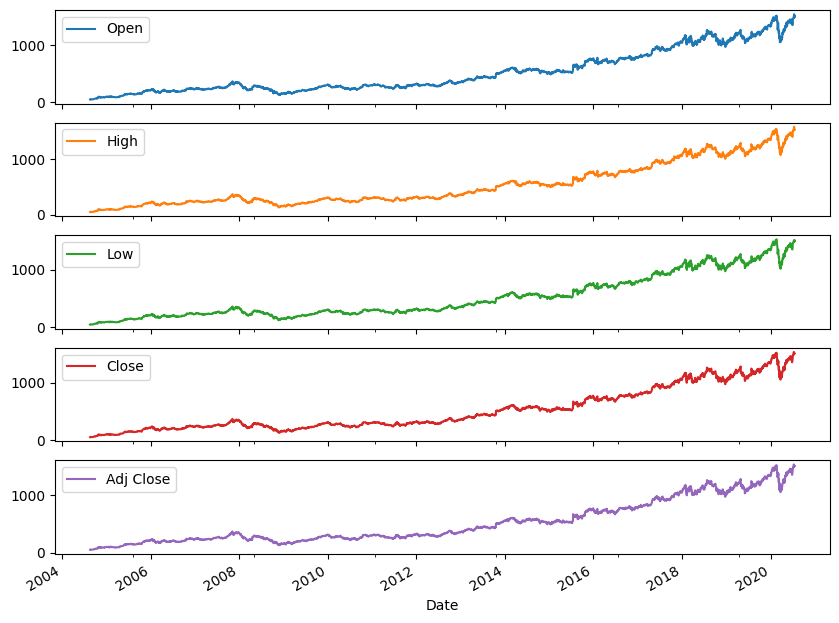

In [6]:
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["axes.grid"] = False
df.set_index("Date")[["Open", "High", "Low", "Close", "Adj Close"]].plot(subplots=True)

Taking 5 features as the input to the time series - open, high, low, close, Adjusted close

In [7]:
df_input = df[["Open", "High", "Low", "Close", "Adj Close",]]

## Data Preprocessing
### 1. Standardization of data

**StandardScaler()**

LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be
normalized.

Since there are 5 features used in this example for prediction and have different scales,
they are Standardized to have a common scale while building the model.

StandardScaler() will normalize the features i.e. each column of X, INDIVIDUALLY, so that
each column/feature/variable will have mean = 0 and standard deviation = 1

In [8]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled

array([[-1.27195197, -1.26786213, -1.2745642 , -1.27028724, -1.27028724],
       [-1.27058974, -1.26115415, -1.26838862, -1.2595499 , -1.2595499 ],
       [-1.25745309, -1.25527464, -1.25675839, -1.25808143, -1.25808143],
       ...,
       [ 2.71716347,  2.71164316,  2.68552176,  2.68823148,  2.68823148],
       [ 2.65453724,  2.66700596,  2.65359982,  2.70002324,  2.70002324],
       [ 2.713075  ,  2.67974794,  2.68666878,  2.69339725,  2.69339725]])

**Set the features and target for the model**

1. features = Open, High, Low, Close, Adj close
2. target = Open

In [9]:
features = data_scaled
target = data_scaled[:, 0]  # Target Column - Open Price

Split the data into training and testing.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=123, shuffle=False
)

print(x_train.shape)

(3004, 5)


**Training Data**

1. Size: 3004
2. features: 5

In [11]:
print(x_test.shape)

(1002, 5)


**Testing Data**

1. Size: 1002
2. features: 5

### 2. TimeseriesGenerator

**TimeseriesGenerator()** is used to automatically transform both univariate and
multivariate time series data into samples, ready to train deep learning models.

In this example, Keras TimeseriesGenerator is used for preparing time series data for
modelling with deep learning methods.

Arguments that are passed to TimeseriesGenerator:
1. features: Passing the scaled multivariate data
2. target: Passing the scaled target column
3. length: It is the window_length
4. Sampling_rate: Period between successive individual timesteps within sequences.
5. batch_size: Number of time-series samples in each batch

To know more about TimeseriesGenerator, check the Keras documentation:
[TimeseriesGenerator](https://keras.io/api/preprocessing/timeseries/)

In [12]:
# This code block is for the understanding the output of TimeseriesGenerator
print("Input Features\n", data_scaled[0:3])
print("\nTimeseriesGenerator")
print(TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0])

Input Features
 [[-1.27195197 -1.26786213 -1.2745642  -1.27028724 -1.27028724]
 [-1.27058974 -1.26115415 -1.26838862 -1.2595499  -1.2595499 ]
 [-1.25745309 -1.25527464 -1.25675839 -1.25808143 -1.25808143]]

TimeseriesGenerator
(array([[[-1.27195197, -1.26786213, -1.2745642 , -1.27028724,
         -1.27028724],
        [-1.27058974, -1.26115415, -1.26838862, -1.2595499 ,
         -1.2595499 ]]]), array([-1.25745309]))


From the above output, it can be observed that the opening price of 3rd day is made as
the target value for the input features of first two days.

## Build the model

### 1. Set the parameters

In [13]:
win_length = 60  # window length
batch_size = 62
num_features = 5
train_generator = TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size
)
test_generator = TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size
)

### 2. Build the model using LSTM

**Leaky ReLU**

Leaky ReLU function is an improved version of the ReLU activation function. As for the
ReLU activation function, the gradient is 0 for all the values of inputs that are less
than zero, which would deactivate the neurons in that region and may cause a dying ReLU
problem.

Leaky ReLU is defined to address this problem. Instead of defining the ReLU activation
function as 0 for negative values of inputs(x), we define it as an extremely small linear
component of x. Here is the formula for this activation function:

f(x)=max(0.01*x , x)

For reference, Relu formula: f(x) = max(0,x)

This function returns x if it receives any positive input, but for any negative value of
x, it returns a really small value which is 0.01 times x.

**Why LSTM?**

Recurrent neural networks are much more flexible and much better suited to time series
forecasting than the linear models usually applied.

Recurrent neural networks, of which LSTMs (“long short-term memory” units) are the most
powerful and well-known subset, are a type of artificial neural network designed to
recognize patterns in sequences of data, such as numerical times series data.

In [14]:
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.LSTM(
        256, input_shape=(win_length, num_features), return_sequences=True
    )
)
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

**summary of the model**

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 256)           268288    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 60, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           197120    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60, 128)           0         
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

## Train the model

In [16]:
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()],
)

history = model.fit(
    train_generator, epochs=50, validation_data=test_generator, shuffle=False
)

Epoch 1/50
48/48 [==============================] - 31s 531ms/step - loss: 0.0626 - mean_absolute_error: 0.1574 - val_loss: 0.0731 - val_mean_absolute_error: 0.2099
Epoch 2/50
48/48 [==============================] - 25s 522ms/step - loss: 0.0336 - mean_absolute_error: 0.1423 - val_loss: 0.0794 - val_mean_absolute_error: 0.2567
Epoch 3/50
48/48 [==============================] - 24s 512ms/step - loss: 0.0327 - mean_absolute_error: 0.1357 - val_loss: 0.0410 - val_mean_absolute_error: 0.1691
Epoch 4/50
48/48 [==============================] - 23s 475ms/step - loss: 0.0431 - mean_absolute_error: 0.1474 - val_loss: 0.0222 - val_mean_absolute_error: 0.1032
Epoch 5/50
48/48 [==============================] - 24s 512ms/step - loss: 0.0323 - mean_absolute_error: 0.1268 - val_loss: 0.0171 - val_mean_absolute_error: 0.0967
Epoch 6/50
48/48 [==============================] - 23s 470ms/step - loss: 0.0233 - mean_absolute_error: 0.1086 - val_loss: 0.0179 - val_mean_absolute_error: 0.1100
Epoch 7/50

## Evaluate model on Test data

### 1. Visualize the training and validation loss

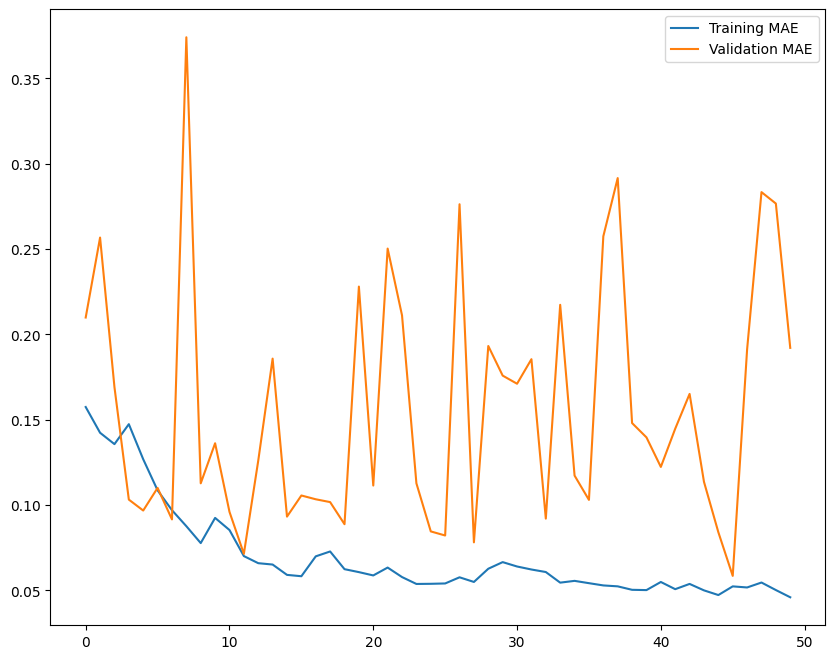

In [17]:
plt.plot(history.history["mean_absolute_error"], label="Training MAE")
plt.plot(history.history["val_mean_absolute_error"], label="Validation MAE")
plt.legend()
plt.show()

### 2. Test Loss and MAE

In [18]:
test_loss, test_mae = model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

Test Loss: 0.05943688750267029
Test MAE: 0.19207720458507538


## Predictions

In [19]:
predictions = model.predict(test_generator)

print(predictions.shape[0])

16/16 [==============================] - 5s 152ms/step
942


The shape of output is 942 and not 1002 when compared with x_test, since the first 60
days are used to determine the next day.

In [20]:
# Consider only the 942 values after the first 60 values
print(x_test[:, 1:][win_length:])

[[0.75144424 0.77410068 0.76222089 0.76222089]
 [0.74975424 0.76863925 0.74996925 0.74996925]
 [0.73776344 0.76309581 0.75646021 0.75646021]
 ...
 [2.71164316 2.68552176 2.68823148 2.68823148]
 [2.66700596 2.65359982 2.70002324 2.70002324]
 [2.67974794 2.68666878 2.69339725 2.69339725]]


Concatenate the prediction dataframe with the x_test

In [21]:
df_pred = pd.concat(
    [pd.DataFrame(predictions), pd.DataFrame(x_test[:, 1:][win_length:])], axis=1
)

df_pred

,0,0,1,2,3
0,0.734924,0.751444,0.774101,0.762221,0.762221
1,0.745559,0.749754,0.768639,0.749969,0.749969
2,0.759495,0.737763,0.763096,0.756460,0.756460
3,0.770891,0.779825,0.792642,0.793621,0.793621
4,0.782515,0.783849,0.793516,0.778908,0.778908
...,...,...,...,...,...
937,2.159409,2.823778,2.705300,2.682011,2.682011
938,2.170550,2.678434,2.645926,2.707001,2.707001
939,2.163583,2.711643,2.685522,2.688231,2.688231
940,2.145119,2.667006,2.653600,2.700023,2.700023


**inverse_transform()** is used to scale back the data to the original representation.

In [22]:
# To get the original values, the inverse_transform has to be performed.
in_trans = scaler.inverse_transform(df_pred)

print(in_trans)

[[ 791.02102715  804.599976    798.030029    801.5         801.5       ]
 [ 794.94914519  803.969971    796.030029    796.969971    796.969971  ]
 [ 800.09613623  799.5         794.          799.369995    799.369995  ]
 ...
 [1318.67365037 1535.329956   1498.         1513.640015   1513.640015  ]
 [1311.85440733 1518.689941   1486.310059   1518.         1518.        ]
 [1303.01181046 1523.439941   1498.420044   1515.550049   1515.550049  ]]


Take only last 942 rows to compare the actual opening and the predicted opening price,
since first 60 days are used to predict the upcoming day.

In [23]:
df_final = df_input[predictions.shape[0] * -1 :]

# Add the Predicted Open price into the final dataframe
predicted_open = in_trans[:, 0].tolist()
df_final.insert(5, "Predicted Open", predicted_open)

df_final

,Open,High,Low,Close,Adj Close,Predicted Open
3064,798.239990,804.599976,798.030029,801.500000,801.500000,791.021027
3065,803.299988,803.969971,796.030029,796.969971,796.969971,794.949145
3066,795.000000,799.500000,794.000000,799.369995,799.369995,800.096136
3067,804.900024,815.179993,804.820007,813.109985,813.109985,804.304955
3068,816.679993,816.679993,805.140015,807.669983,807.669983,808.598154
...,...,...,...,...,...,...
4001,1550.000000,1577.131958,1505.243042,1511.339966,1511.339966,1317.132140
4002,1490.310059,1522.949951,1483.500000,1520.579956,1520.579956,1321.247091
4003,1523.130005,1535.329956,1498.000000,1513.640015,1513.640015,1318.673650
4004,1500.000000,1518.689941,1486.310059,1518.000000,1518.000000,1311.854407


## Visualize the Predictions

<Axes: >

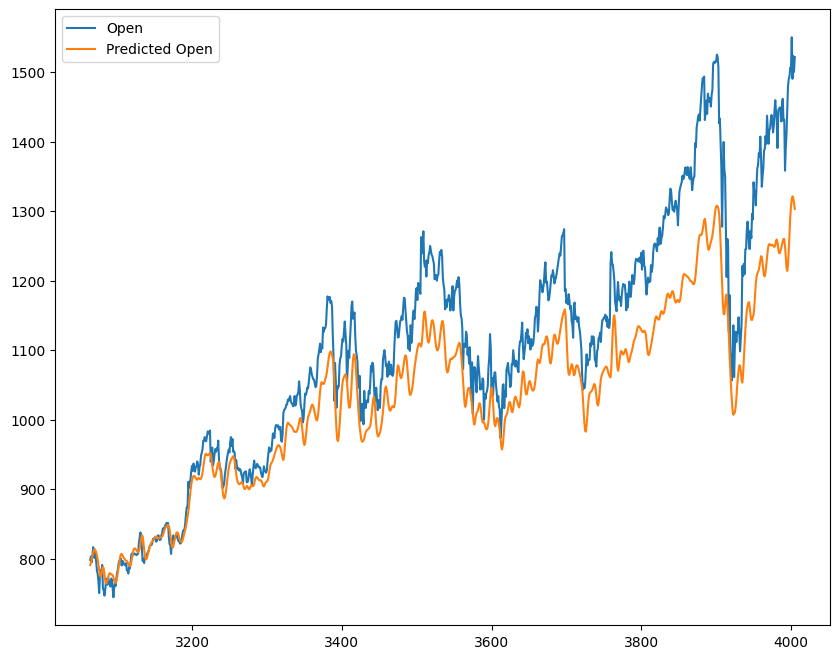

In [24]:
df_final[["Open", "Predicted Open"]].plot()